#### Import des bibliothèqes :

In [369]:
import random
from math import ceil, gcd
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import kurtosis, skew
from statsmodels.graphics.gofplots import qqplot_2samples

#### Fonctions utilitaires :

In [370]:

def get_seed():
    return random.random() * 1_000_000  # if int is returned, Mitchell & Moore bug


def linear_congruential_generator(m: int, a: int, c: int, seed: int, n: int) -> List[int]:
    res = [seed]
    for i in range(n):
        seed = (a * seed + c) % m
        res.append(seed)
    return res

# I - Présentation des générateurs

## a - Park & Miller / Standard Minimal

Le générateur de nombres pseudo-aléatoires Park & Miller est un générateur standard convenablement testé et portable.
Il utilise le Générateur Congruentiel Linéraire avec les paramètres suivants :
- m = 2^31 - 1,
- a = 16807,
- c = 0.

Avec ce type de générateur, chaque valeur générée dépend de la valeur précédente.

In [371]:
def park_miller(seed: int, n: int) -> List[int]:
    if seed == 0:
        raise ValueError("Park-Miller should not start with a seed equal to 0.")
    m = pow(2, 31) - 1
    return linear_congruential_generator(m, 16807, 0, seed, n)


def park_miller_normalized(seed: int, n: int) -> List[float]:
    return [elem / (pow(2, 31) - 1) for elem in park_miller(seed, n)]

## b - Mitchell & Moore

Le générateur de nombres aléatoires Mitchell & Moore utilise une suite de Fibonacci "retardée",
avec les paramètres suivants :

- k = 55
- l = 24

Ces paramètres nécessitent d'initialiser le générateur avec 56 nombres pseudo-aléatoires.
Pour ce faire, j'ai choisi d'utilisé le générateur Parker & Miller vu ci-dessus.

Les générateurs basés sur des suites de Fibonacci "retardées" produisent des résultats bien supérieurs
à ceux basés sur des congruences linéaires, grâce au "décalage" introduit qui évite de générer une valeur aléatoire
liée à la précédente.

In [372]:
def mitchell_moore(n: int, m: int) -> List[float]:
    res = park_miller(get_seed(), 56)

    for i in range(57, 57 + n):
        res.append((res[i - 24] + res[i - 55]) % m)

    return [e / m for e in res[57:]]  # normalisation

## c - Blum Blum Shub

In [373]:
def blum_blum_shub(n: int) -> List[float]:  # intéret --> difficile à hacker
    seed = get_seed()
    m = 56923661
    if seed == 0 or seed == 1:
        raise ValueError("Seed should not be equal to 0 or 1.")
    # if gcd(m, seed) != 1:
    #     raise ValueError(f"Seed should be prime with modulo : {m}")

    res = [seed]
    for i in range(n):
        seed = (seed * seed) % m
        res.append(seed)
    return [e / m for e in res]  # normalisation

## d - Mersenne Twister

Ce générateur est intégré à la bibliothèque random en Python.

In [374]:
def mersenne_twister(n: int) -> List[float]:
    return [random.random() for _ in range(n)]

# II - Test des générateurs

## a - Interprétation graphique

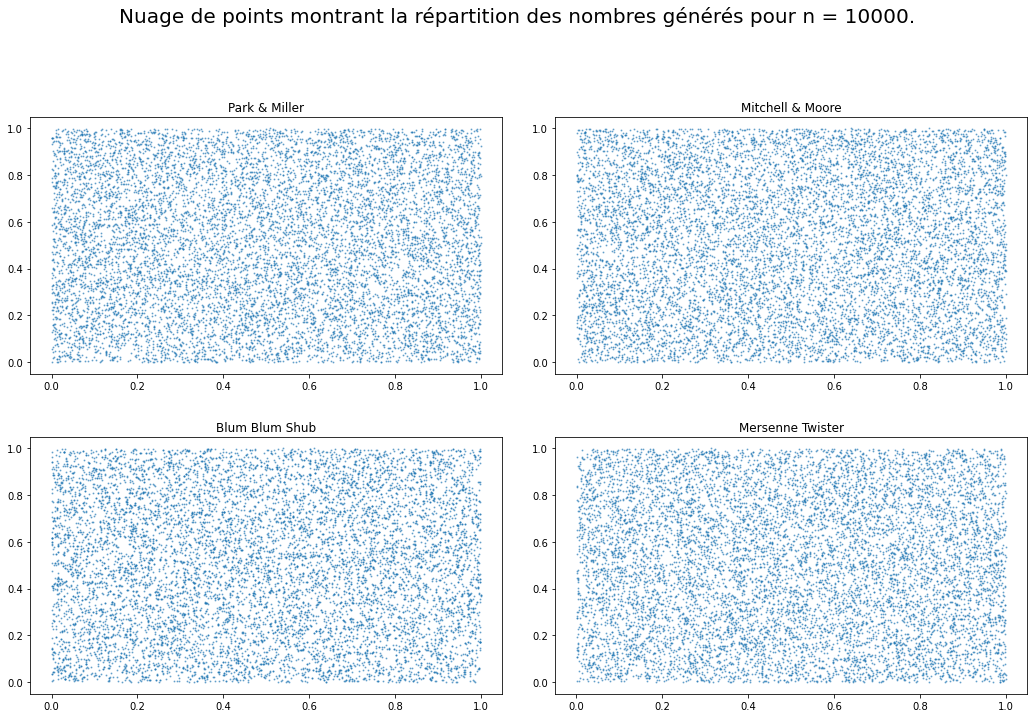

In [375]:
ALGORITHMS = ['Park & Miller', 'Mitchell & Moore', 'Blum Blum Shub', 'Mersenne Twister']


def scatter_plot(l1: List[List[float]], l2: List[List[float]], title: str, subtitles: List[str]) -> None:
    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.suptitle(title, fontsize=20, y=1.02)
    fig.set_size_inches(15, 10)
    i = 0
    for row in ax:
        for col in row:
            col.scatter(l1[i], l2[i], alpha=0.5, s=1)
            col.title.set_text(subtitles[i])
            i += 1
    fig.tight_layout(pad=3.0)
    plt.show()


n = 10_000
title = f'Nuage de points montrant la répartition des nombres générés pour n = {n}.'
l1 = [park_miller_normalized(get_seed(), n),
      mitchell_moore(n, 1000),
      blum_blum_shub(n),
      mersenne_twister(n)]
l2 = [park_miller_normalized(get_seed(), n),
      mitchell_moore(n, 1000),
      blum_blum_shub(n),
      mersenne_twister(n)]

scatter_plot(l1, l2, title, ALGORITHMS)

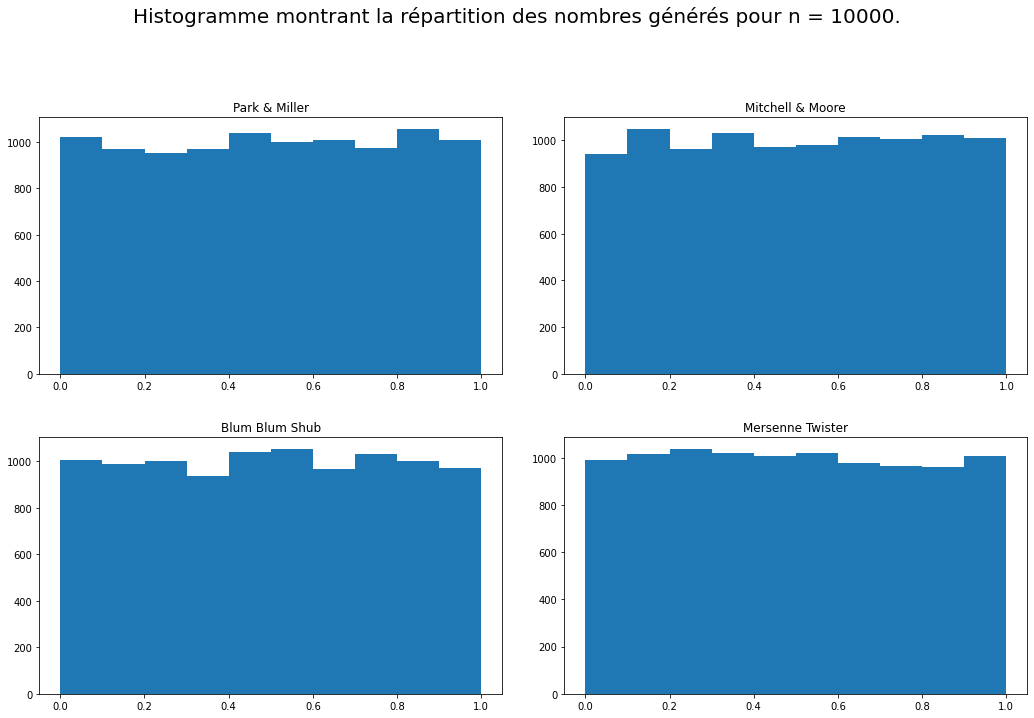

In [376]:
def histo_plot(l: List[List[float]], title: str, subtitles: List[str]) -> None:
    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.suptitle(title, fontsize=20, y=1.02)
    fig.set_size_inches(15, 10)
    i = 0
    for row in ax:
        for col in row:
            col.hist(l[i])
            col.title.set_text(subtitles[i])
            i += 1
    fig.tight_layout(pad=3.0)
    plt.show()


n = 10_000
l = [park_miller_normalized(get_seed(), n),
     mitchell_moore(n, 1000),
     blum_blum_shub(n),
     [random.random() for i in range(n)]]
title = f'Histogramme montrant la répartition des nombres générés pour n = {n}.'

histo_plot(l, title, ALGORITHMS)

c:\users\maxim\documents\projets\pgc-gva\pgc-gva-tp1-generateurs\venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
c:\users\maxim\documents\projets\pgc-gva\pgc-gva-tp1-generateurs\venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
c:\users\maxim\documents\projets\pgc-gva\pgc-gva-tp1-generateurs\venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
c:\users\maxim\documents\projets\pgc-

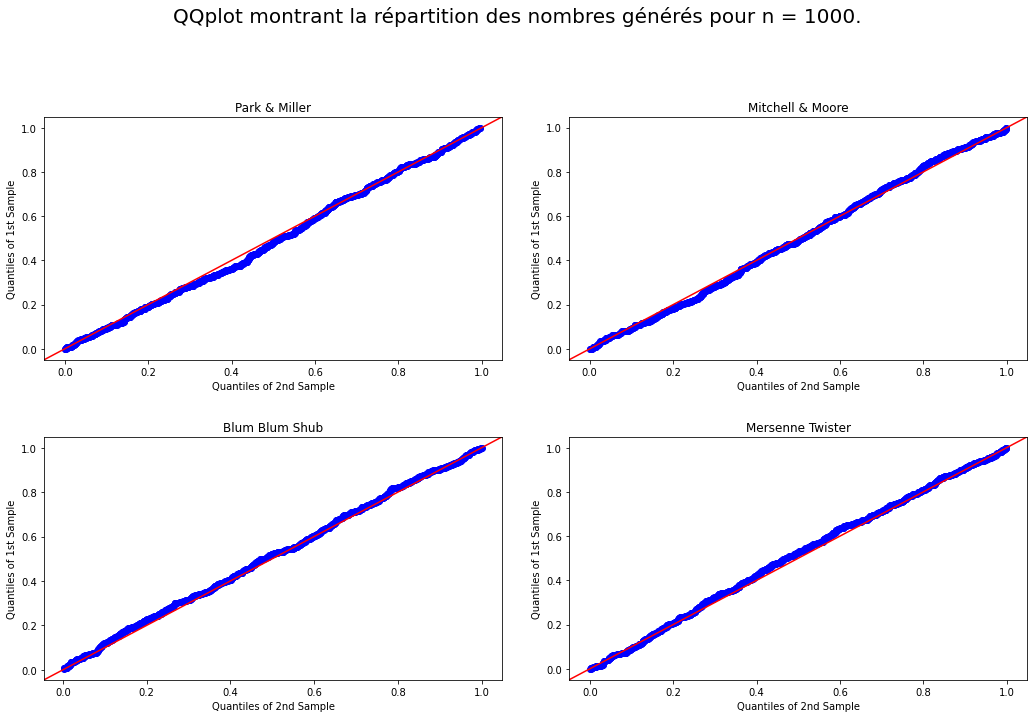

In [377]:
def qq_plot(l1: List[List[float]], l2: List[List[float]], title: str, subtitles: List[str]) -> None:
    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.suptitle(title, fontsize=20, y=1.02)
    fig.set_size_inches(15, 10)
    i = 0
    for row in ax:
        for col in row:
            pp_x = sm.ProbPlot(np.array(l1[i]))
            pp_y = sm.ProbPlot(np.array(l2[i]))
            qqplot_2samples(pp_x, pp_y, line="45", ax=col)
            col.title.set_text(subtitles[i])
            i += 1
    fig.tight_layout(pad=3.0)
    plt.show()


n = 1000
title = f'QQplot montrant la répartition des nombres générés pour n = {n}.'

l1 = [park_miller_normalized(get_seed(), n),
      mitchell_moore(n, 1000),
      blum_blum_shub(n),
      mersenne_twister(n)]
l2 = [park_miller_normalized(get_seed(), n),
      mitchell_moore(n, 1000),
      blum_blum_shub(n),
      mersenne_twister(n)]

qq_plot(l1, l2, f'QQplot montrant la répartition des nombres générés pour n = {n}.', ALGORITHMS)

## b - Tests Mathématiques

### Equiprobabilité

In [378]:
def get_percentile(values: List[float], percentage: float) -> float:
    sorted_list = sorted(values)
    return sorted_list[ceil(len(values) * (percentage / 100))]


n = 1_000_000

l = [park_miller_normalized(get_seed(), n),
     mitchell_moore(n, 1000),
     blum_blum_shub(n),
     mersenne_twister(n)]

data = {'Quartile 25%': [get_percentile(sublist, 25) for sublist in l],
        'Mean value': [get_percentile(sublist, 50) for sublist in l],
        'Quartile 75%': [get_percentile(sublist, 75) for sublist in l],
        'Variance': [np.var(sublist) for sublist in l],
        'Kurtosis (normalised)': [kurtosis(sublist) for sublist in l],
        'Skewness': [skew(sublist) for sublist in l]}

pd.DataFrame.from_dict(data, orient='index', columns=ALGORITHMS)

,Park & Miller,Mitchell & Moore,Blum Blum Shub,Mersenne Twister
Quartile 25%,0.250004,0.250617,0.246295,0.249226
Mean value,0.500537,0.500938,0.497016,0.499515
Quartile 75%,0.750206,0.750459,0.751052,0.749638
Variance,0.083319,0.083371,0.083503,0.083342
Kurtosis (normalised),-1.200371,-1.200175,-1.212536,-1.201317
Skewness,-0.002023,-0.003210,0.009349,0.000596


### Tests quantitatifs usuels